In [ ]:
import torch
import torch.nn as nn
import torch

The original proposed GANs are very difficult to train because of the nature of JS divergnece. Given a perfect discriminator, if the real distribution does not overlap with the generated distribution, then the JS divergence of of two distribution will be evaluated to a constant log2. As a result, the gradients are to flat near generated distribution (close to 0) and fail to guide the learning of generator. In words, the gradient is close to 0, then the difference of update is close to 0, which means the generator network is learning nothing.

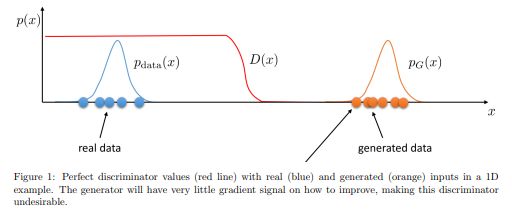

The key idea to improve GAN training is that we don’t actually care how well the discriminator does by
itself, but rather we only care that it provides a useful signal to improve the generator. A common way
we can accomplish this is to restrict the expressivity of discriminator, often by enforcing some additional
smoothness condition. As we see in the figure below, the smoother discriminator values in green can provide a more useful learning signal for the generator.


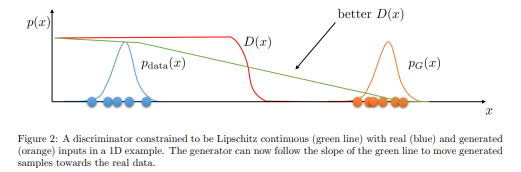

Ignore the math behind, we have a new distance measure, called Wasserstein distance W(p,$p_G$) as
\begin{equation}
W(p,p_G) = \sup_{||f||_L \le 1} E_{X \sim p(X)}[f(x)]-E_{̃X ∼p_G(X)}[f(x)]
\end{equation}
where f is restricted to be 1-Lipschitz function. The original WGAN paper suggested approximating f (discriminator) with a neural net parameterized by $ϕ$ enforcing a Lipschitz constraint by cliping the each entry of the weights $ϕ$ to have magnitude less than $ϵ$.

In [ ]:
# based on DCGAN model setting
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
# test on model accuracy
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Success, tests passed!")

test()

Success, tests passed!


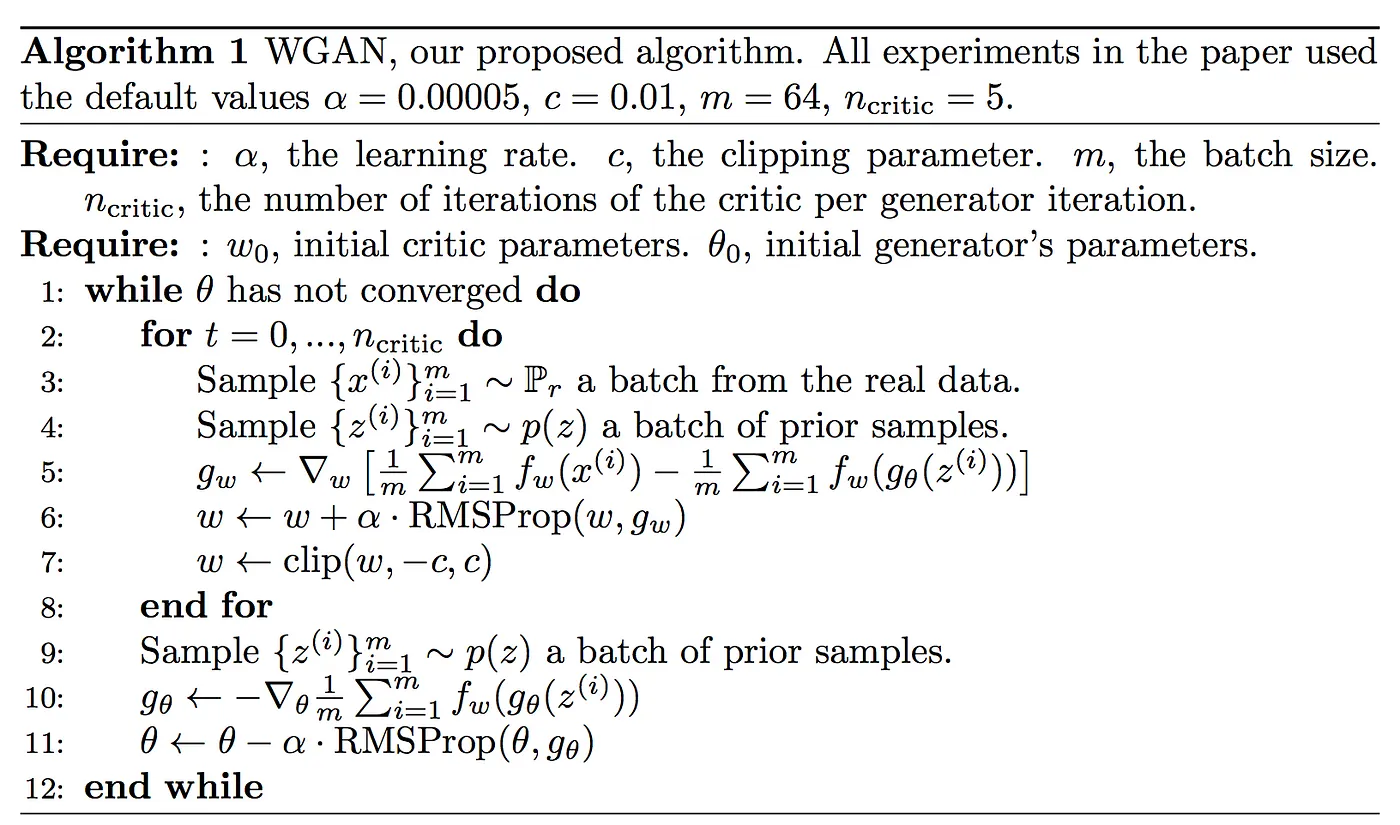

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# CHANGE LEARNING RATE TO 1e-4 IF GRADIENT PENALTY
LEARNING_RATE = 5e-5  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01
# UNCOMMENT THIS BLOCK IF GRADIENT PENALTY
# LAMBDA_GP = 10

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

# If you train on MNIST, remember to set channels_img to 1
dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms, download=True
)

# comment mnist above and uncomment below if train on CelebA
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# CHANGE OPTIMIZER IF GRADIENT PENALTY
# opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
# opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)


fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(CRITIC_ITERATIONS):
          noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
          fake = gen(noise)
          critic_real = critic(real).reshape(-1)
          critic_fake = critic(fake).reshape(-1)

          # UNCOMMENT THIS BLOCK IF GRADIENT PENALTY
          # gp = gradient_penalty(critic, real, fake, device=device)

          # CHANGE LOSS_CRITIC IF GRADIENT PENALTY
          # loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake) + LAMBDA_GP * gp)
          loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
          critic.zero_grad()
          loss_critic.backward(retain_graph=True)
          opt_critic.step()

          # COMMENT THIS BLOCK IF GRADIENT PENALTY
          # clip critic weights between -0.01 and 0.01
          for p in critic.parameters():
            p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        ### Train generator: min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

Epoch [0/5] Batch 0/938                   Loss D: -0.0381, loss G: 0.0184
Epoch [0/5] Batch 100/938                   Loss D: -1.3797, loss G: 0.6802
Epoch [0/5] Batch 200/938                   Loss D: -1.5226, loss G: 0.7514
Epoch [0/5] Batch 300/938                   Loss D: -1.5325, loss G: 0.7547
Epoch [0/5] Batch 400/938                   Loss D: -1.5380, loss G: 0.7571
Epoch [0/5] Batch 500/938                   Loss D: -1.5226, loss G: 0.7503
Epoch [0/5] Batch 600/938                   Loss D: -1.5372, loss G: 0.7574
Epoch [0/5] Batch 700/938                   Loss D: -1.5358, loss G: 0.7564
Epoch [0/5] Batch 800/938                   Loss D: -1.4968, loss G: 0.7381
Epoch [0/5] Batch 900/938                   Loss D: -1.4298, loss G: 0.7145
Epoch [1/5] Batch 0/938                   Loss D: -1.4481, loss G: 0.7090
Epoch [1/5] Batch 100/938                   Loss D: -1.4382, loss G: 0.6181
Epoch [1/5] Batch 200/938                   Loss D: -1.3863, loss G: 0.5841
Epoch [1/5] Batc

But as the paper mentioned, weight clipping is a terrible way to enforce a Lipschitz constraint. If the clipping parameter is latge, then it can take a long time for any weights to reach their limit, thereby making it harder to train the critic till optimality. Our goal now is to improve training of WGAN. Recall regularization is one useful technique to limit the power of model, we may implement regularization (gradient penalty) on the discriminator loss to enforce a Lipschitz constraint. WIth additional penalty term in discriminator loss,
\begin{equation}
penalty = λ(||∇_{x̂}D_w(x̂)||_2-1)^2
\end{equation}
we may enforce the magnitude of parameters is close to 1. Implementation details can refer from [here](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py).

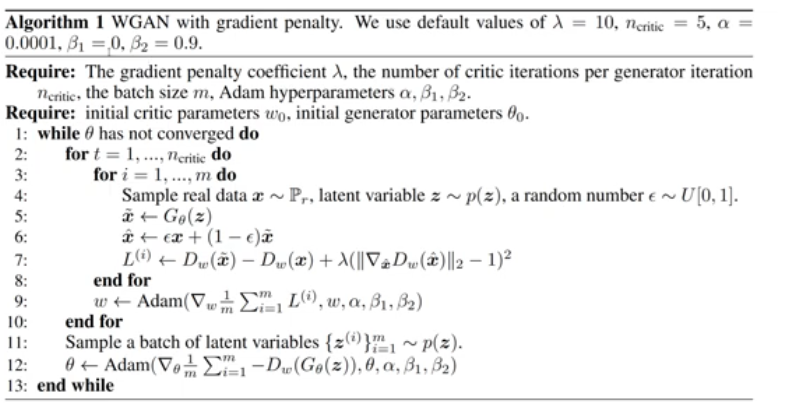

In [ ]:
# PUT IT INTO FILE util.py IN REAL APPLICATION
# CHANGE SOME CODE STRUCTURE ABOVE IF GRADIENT PENALTY
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)

    # calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of scores wrt the images
    gradient = torch.autograd.grad(
      inputs = interpolated_images,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores),
      create_graph=True,
      retain_grap=True,
    )[0]

    # Flatten the dimension
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

